In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pulp import *

In [2]:
# importing the data to take a look at what we have

df = pd.read_csv('../data/family_data.csv',index_col=0)

df.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [3]:
# for testing
num_days=100
num_families = 5000

In [4]:
df2 = df[:num_families].copy()

In [5]:
#people scaling 
people_scale = df2.n_people.sum()/df.n_people.sum()

max_people = np.around(1.5*df2.n_people.sum()/num_days)
min_people = np.around(df2.n_people.sum()/2/num_days)

if num_days==100 and num_families==5000:
    max_people = 300
    min_people = 125

# day scaling
day_scale = num_days/100

In [6]:
print(max_people)
print(min_people)
print(day_scale)
print(people_scale)

300
125
1.0
1.0


In [7]:
if num_days!=100:
    for c in df2.columns.tolist()[:10]:
        df2[c] = np.random.randint(1,num_days+1,num_families)

In [8]:
df2.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [9]:
# I'm going to add a column which will represent the choice falling outside of any of the given choices. 
# This will be choice_10, and it will be 101,,,

In [10]:
df2.describe()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000
mean,40.715000,41.601000,41.194200,41.595000,41.950600,42.63520,41.965000,42.739600,42.33900,42.608200,4.20060
std,29.054208,29.518375,28.821878,29.094602,29.045049,28.98729,28.711089,28.959156,28.69832,28.116088,1.53272
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,2.00000
25%,16.000000,16.000000,17.000000,17.000000,17.000000,18.00000,17.000000,18.000000,17.00000,19.000000,3.00000
50%,38.000000,38.000000,38.000000,39.000000,39.000000,40.00000,39.000000,39.000000,39.00000,39.000000,4.00000
75%,62.000000,66.000000,63.000000,66.000000,66.000000,66.00000,66.000000,67.000000,66.00000,66.000000,5.00000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000,8.00000


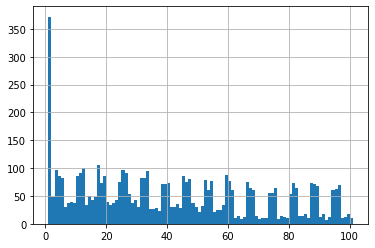

In [11]:
df2['choice_0'].hist(bins=[b for b in range(1,num_days+2,1)])

In [12]:
lower_limit = min_people
upper_limit = max_people

# creating the decision variables
choice = ['choice_0','choice_1', 'choice_2', 'choice_3', 'choice_4', 'choice_5', 
          'choice_6', 'choice_7', 'choice_8', 'choice_9','choice_10']
day = [i for i in range(1,num_days+1)]
fam_id = df2.index.tolist()

Create a lookup table for the accounting penalty

In [13]:
def accounting_penalty_actual(Nd,diff):
    return 300/max_people*(Nd-min_people)/400 * Nd**(0.5+diff/50)

In [14]:
acc_table = {}
for Nd in range(int(min_people),int(max_people)+1,1):
    acc_table[Nd] = [accounting_penalty_actual(Nd,diff) for diff in range(0,int(max_people-min_people)+1,1)]

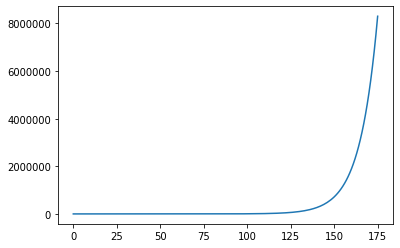

In [15]:
plt.plot(np.arange(0,int(max_people-min_people+1),1),acc_table[int(min_people+10)][:int(max_people-min_people+1)])

In [29]:
from scipy.optimize import linprog

In [ ]:
# create the matrix of decision variables
x = np.array([0])

The decision variable needs to be a boolean for each choice for each family. We will create a 

In [16]:
# The prob variable is created to contain the problem data        
prob = LpProblem("Santa",LpMinimize)

In [17]:
# The decision variables are actually the family and the day they are assigned
selection = LpVariable.dicts("sel",(fam_id,day),0,1,LpInteger)

In [18]:
# adding in the constraints

# The first set of constraints ensures each family only has a single day selected
for f in fam_id:
        prob += lpSum([selection[f][d] for d in day]) == 1, ''

In [19]:
# the second set of constraints guarantee that the total number of visitors is between 125 and 300 for
# for every single day leading up to christmas

for d in day:
    prob += lpSum([selection[f][d]*df2['n_people'][f] for f in fam_id]) >= lower_limit, ''
    prob += lpSum([selection[f][d]*df2['n_people'][f] for f in fam_id]) <= upper_limit, ''

In [20]:
def ppd(d):
    if d>num_days:
        d=num_days
    return lpSum([selection[f][d]*df2['n_people'][f] for f in fam_id])

In [21]:
# adding this third constraint to prevent the difference between each day from climbing too high.
max_diff = 50

for d in day[0:len(day)-1]:
    prob += ppd(d+1)-ppd(d) >= -max_diff, ''
    prob += ppd(d+1)-ppd(d) <= max_diff, ''


Now we need to write down the objective function. How do we figure out how to flag for choice? Can we create a vector of choice for each family member?

Can we do some sort of mod of the day in the choice dictionary over the selected day?

I think we need to place a vector of length 11 in every single day for every single family. The location that is 1 will be the choice for that day. If the day is not one of the choices, the 11th element will be 1. This will then be used to multiply by the matrix for penalties.

Need to do some sort of 

In [22]:
choice_matrix = {}

for f in fam_id:
    
    if f%100==0:
        print('{}/{}'.format(f,len(df2)))
    
    choice_matrix[f] = {}
    
    for d in day:
        
        choice_to_check = df2.loc[f,df2.columns.tolist()[:10]].values
        
        if d in choice_to_check:
            c_loc = np.where(choice_to_check==d)[0][0]
        else:
            c_loc = 10
            
            
        choice_matrix[f][d] = {c:(0 if i!=c_loc else 1) for i,c in enumerate(choice)} 

0/5000
100/5000
200/5000
300/5000
400/5000
500/5000
600/5000
700/5000
800/5000
900/5000
1000/5000
1100/5000
1200/5000
1300/5000
1400/5000
1500/5000
1600/5000
1700/5000
1800/5000
1900/5000
2000/5000
2100/5000
2200/5000
2300/5000
2400/5000
2500/5000
2600/5000
2700/5000
2800/5000
2900/5000
3000/5000
3100/5000
3200/5000
3300/5000
3400/5000
3500/5000
3600/5000
3700/5000
3800/5000
3900/5000
4000/5000
4100/5000
4200/5000
4300/5000
4400/5000
4500/5000
4600/5000
4700/5000
4800/5000
4900/5000


In [23]:
choice_matrix[0][16]

{'choice_0': 0,
 'choice_1': 0,
 'choice_2': 0,
 'choice_3': 0,
 'choice_4': 0,
 'choice_5': 0,
 'choice_6': 0,
 'choice_7': 0,
 'choice_8': 0,
 'choice_9': 0,
 'choice_10': 1}

In [24]:
# gift card contribution by choice
choice_gc = {}
choice_gc['choice_0'] = 0
choice_gc['choice_1'] = 50
choice_gc['choice_2'] = 50
choice_gc['choice_3'] = 100
choice_gc['choice_4'] = 200
choice_gc['choice_5'] = 200
choice_gc['choice_6'] = 300
choice_gc['choice_7'] = 300
choice_gc['choice_8'] = 400
choice_gc['choice_9'] = 500
choice_gc['choice_10'] = 500

# per member monetary contribution
choice_pm = {}
choice_pm['choice_0'] = 0
choice_pm['choice_1'] = 0
choice_pm['choice_2'] = 9
choice_pm['choice_3'] = 9
choice_pm['choice_4'] = 9
choice_pm['choice_5'] = 18
choice_pm['choice_6'] = 18
choice_pm['choice_7'] = 36
choice_pm['choice_8'] = 36
choice_pm['choice_9'] = 36+199
choice_pm['choice_10'] = 36+398


In [ ]:
def ppd(d):
    if d>num_days:
        d=num_days
    return lpSum([selection[f][d]*df2['n_people'][f] for f in fam_id])


def accounting_penalty():
    return lpSum( [ 300/max_people*(0.055*(ppd(d)+(125-min_people)) - 6.8) for d in day] )

In [ ]:

#prob += lpSum([selection[f][d]*choice_matrix[f][d][c]*(choice_gc[c]+df2['n_people'][f]*choice_pm[c])
#               for c in choice for d in day for f in fam_id]) \
#        + accounting_penalty() \
 #                , 'Objective Function'

In [25]:
prob += lpSum([selection[f][d]*choice_matrix[f][d][c]*(choice_gc[c]+df2['n_people'][f]*choice_pm[c])
               for c in choice for d in day for f in fam_id]) \
        , 'Objective Function'

In [26]:
import time



In [27]:
tm = time.time()
print(tm)

prob.solve()

tm_final = time.time()
print(tm_final)

print('Total Minutes: {}'.format( (tm_final-tm)/60))

1576338788.0591307


PulpSolverError: Pulp: Error while trying to execute /home/michael/anaconda3/envs/pulp-env/lib/python3.7/site-packages/pulp/solverdir/cbc/linux/64/cbc

In [ ]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

In [ ]:
obj = value(prob.objective)
print(obj)

In [ ]:
fam_day_dict = {}

for f in fam_id:
    for d in day:
        if value(selection[f][d])==1:
            fam_day_dict[f] = d

In [ ]:
sel_series = pd.Series(fam_day_dict,name='assigned_day')

In [ ]:
sel_series.hist(bins=[b for b in range(1,num_days+2,1)])

In [ ]:
df2 = df2.join(sel_series)
df2.head()

In [ ]:
df2['assigned_day'].to_csv('submission.csv',header=True)

In [ ]:
total_people = {}
for d in day:
    mask = df2['assigned_day']==d
    total_people[d] = df2[mask].n_people.sum()
    print(total_people[d])

Calculating the actual objective for the problem

In [ ]:
def accounting_penalty_actual(Nd,diff):
    return 300/max_people*(Nd-min_people)/400 * Nd**(0.5+np.fabs(diff)/50)

In [ ]:
total_accounting_penalty = sum([accounting_penalty_actual(total_people[d],total_people[d]-total_people[d+1])
                                if d<100 
                                else accounting_penalty_actual(total_people[d],0)
                                for d in day])
print(total_accounting_penalty)

In [ ]:
final_score = value(prob.objective) + total_accounting_penalty
print('Final Score: {}'.format(final_score))

with a limit of 50, the final score was 7684

In [ ]:
t = df.loc[0,df.columns.tolist()[:10]].values

In [ ]:
val = 28

if val in t:
    loc = np.where(t==val)[0][0]
else:
    loc = 10
    
print(loc)

In [ ]:
501%50

In [ ]:
x = [0,1,2]
y = [3,4,5]
z = [6,7,8]

In [ ]:
l = [a*b*c for a in x for b in y for c in z]

In [ ]:
len(l)

In [ ]:
2**(2+1)

In [ ]:
abs(-10.1)

In [ ]:
200*500 + df.n_people.sum()*choice_pm['choice_10']

In [ ]:
df.n_people.sum()

In [ ]:
df.n_people.sum()/20

In [ ]:
def accounting_penalty(x):
    return (x-125)/400 * x**(0.5)*x**(10*np.exp(-(x-125)/100)/50)

def accounting_penalty_lin(x):
    return 300/max_people*(0.055*(x+(125-min_people))-6.8)

In [ ]:
x1 = np.arange(125,300,1)
x2 = np.arange(min_people,max_people,1)

In [ ]:
y1 = accounting_penalty(x1)
y2 = accounting_penalty_lin(x2)

In [ ]:
plt.plot(x1,10*np.exp(-(x1-125)/100))

In [ ]:
plt.plot(x1,x1**(0.5+0/50))

In [ ]:
#plt.plot(x1,y1)
plt.plot(x2,y2)

In [ ]:
plt.plot(x,y)

In [ ]:
max(y)

In [ ]:
15/175

In [ ]:
15/175*125

In [ ]:
plt.plot(x1,(x1-125)/400 * x1**(0.5+50/50))

In [ ]:
(400-125)/100

In [ ]:
c = df['']

Some boneheaded approximations would estimate the accounting penalty to be y(d) = 0.55*d-6.8

In [ ]:
# day scaling
day_scale = num_days/100

In [ ]:
#people scaling 
people_scale = df2.n_people.sum()/df.n_people.sum()

In [ ]:
125*people_scale

In [ ]:
df.n_people.sum()

In [ ]:
21003/100

In [ ]:
200/20

In [ ]:
min_people

In [ ]:
max_people

In [ ]:
v = prob.variables()[0]

In [ ]:
v.name

In [ ]:
print(v.varValue)

In [ ]:
def accounting_penalty_actual(Nd,diff):
    return (Nd-125)/400 * Nd**(0.5+diff/50)

In [ ]:
acc_table = {}
for Nd in range(125,301,1):
    acc_table[Nd] = [accounting_penalty_actual(Nd,diff) for diff in range(0,176,1)]

In [ ]:
acc_table[126][50]

In [ ]:
r = 50
plt.plot(np.arange(0,r,1),acc_table[300][:r])

In [ ]:
d = [1,2,3,4,5]

In [ ]:
d[0:len(d)-1]